<a href="https://colab.research.google.com/github/Neafiol/Tinkoff/blob/master/Copy_of_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np

## Links:
* [Colah blog (LSTM/GRU)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [PyTorch tutorial - RNN for name classification](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)
* [MNIST classification with RNN tutorial](https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79)
* [Good tutorials about Torch sentiment](https://github.com/bentrevett/pytorch-sentiment-analysis)

## Vanilla RNN

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png" width="600">

$$\Large h_{i+1} = tanh(W_x \cdot X_{i+1} + W_y \cdot h_{i})$$

# RNN intro


Давайте разберемся что из себя вообще представляют рекуррентные нейронные сети в самом простом виде.

В самом простом виде для одного входного вектора $x_{(t)}$ и одного слоя рекуррентной сети справедливо такое соотношение:

$$y_{(t)} = \phi (x_{(t)}^T \cdot w_x + y_{(t-1)}^T \cdot w_y + b)$$

где 
* $x(t)$ -- входной вектор на текущем шаге
* $y(t)$ -- выходной вектор на текущем шаге
* $w_x$ -- вектор весов нейронов для входа
* $w_y$ -- вектор весов нейронов для выхода
* $y(t-1)$ -- выходной вектор с прошлого шага. Для шага 0 этот вектор нулевой
* $b$ -- байес (bias)
* $\phi$ -- обозначение для функции активации, например ReLU


<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png" width="600">

Есть понятие **hidden_state** ( $h(t)$ ) -- это "память" рекуррентной ячейки.

В общем случае $h_{(t)} = f(h_{(t-1)}, x_{(t)})$, на выход также $y{(t)} = f(h{(t-1)}, x{(t)})$.


### Упрощение формулы

Снова немножко математики чтобы привести формулу выше к более удобному виду.

Представим, что на вход подается не один вектор $x_{(t)}$, а целый мини-батч размера $m$ таких векторов $X_{(t)}$, соответственно все дальнейшие размышления мы уже производим в матричном виде:

$$ Y_{(t)} = \phi(X_{(t)}^T \cdot W_x + Y_{(t-1)}^T \cdot W_y + b) = \phi([X_{(t)} Y_{(t-1)}] \cdot W + b) $$
где
$$ W = [W_x W_y]^T $$

*Операция в скобках квадратных -- конкатенация матриц

По размерностям:
* $Y_{(t)}$ -- матрица [$m$ x n_neurons]
* $X_{(t)}$ -- матрица [$m$ x n_features]
* $b$ -- вектор длины n_neurons
* $W_x$ -- веса между входами и нейронами размерностью [n_features x n_neurons]
* $W_y$ -- веса связей с прошлым выходом размерностью [n_neurons x n_neurons]

# RNN from scratch

### Задание

Напишите класс RNN реализующий vanilla RNN

In [0]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size

        self.vx = nn.Linear(input_size,hidden_size)      
        self.vh = nn.Linear(hidden_size,hidden_size)        

        
       

    def forward(self, input_data, hidden):
      
        w=torch.cat([self.vx(input_data),self.vh(hidden)])
        w=torch.tanh(w)
        return w

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [0]:
input_feature_size = 6
hidden_size=5
batch_size=1

In [0]:
rnn = RNN(input_size=input_feature_size, hidden_size=hidden_size)
initial_hidden = rnn.initHidden()

In [0]:
input_example = torch.rand([batch_size, input_feature_size])
new_hidden = rnn(input_example, initial_hidden)

In [6]:
print(new_hidden.shape)

torch.Size([2, 5])


In [7]:
print("initial_hidden: ", initial_hidden.numpy())
print("new_hidden: ", new_hidden.detach().numpy())

initial_hidden:  [[0. 0. 0. 0. 0.]]
new_hidden:  [[ 0.13374999 -0.22019383 -0.11869428  0.34385833  0.4082044 ]
 [-0.10096807  0.36108503  0.22438139  0.36570698  0.35673583]]


In [8]:
new_hidden = rnn(input_example, new_hidden)
print("new_hidden: ", new_hidden.detach().numpy())

new_hidden:  [[ 0.13374999 -0.22019383 -0.11869428  0.34385833  0.4082044 ]
 [-0.06931694  0.33059952  0.1227747   0.35185146  0.41445634]
 [ 0.04784166  0.34030536 -0.13984264  0.37678915  0.343393  ]]


### Задание

Модифицировать код так, чтобы на входе можно было подавать батчи размером больше 1.

# Классификация картинок с RNN

<img src="https://cdn-images-1.medium.com/max/2000/1*wFYZpxTTiXVqncOLQd_CIQ.jpeg" width="800">

In [0]:
!mkdir data

Загружаем данные

In [10]:
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 64

# переводим все в тензоры
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

0it [00:00, ?it/s]

9920512it [00:01, 9157811.54it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 136356.96it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2223093.59it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 50885.90it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [11]:
!ls -lh data/

total 4.0K
drwxr-xr-x 4 root root 4.0K Mar 23 13:02 MNIST


Populating the interactive namespace from numpy and matplotlib


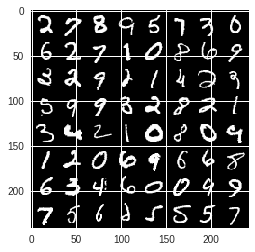

In [12]:
%pylab inline
import numpy as np

# functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## Как выглядит классификация с RNN в общем виде 

<img src="https://cdn-images-1.medium.com/max/1600/1*vhAfRLlaeOXZ-bruv7Ostg.png" width="400">

In [0]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(ImageRNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

In [0]:
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 10

In [15]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
print(logits[0:10])

tensor([[ 0.0218,  0.1082, -0.0494, -0.0715, -0.0988,  0.1466, -0.0330, -0.0458,
         -0.1293, -0.0547],
        [ 0.0280,  0.1114, -0.0571, -0.0529, -0.0989,  0.1360, -0.0210, -0.0434,
         -0.1379, -0.0463],
        [ 0.0275,  0.1075, -0.0519, -0.0406, -0.1157,  0.1198, -0.0145, -0.0560,
         -0.1279, -0.0600],
        [ 0.0258,  0.1012, -0.0478, -0.0793, -0.0882,  0.1344, -0.0351, -0.0386,
         -0.1279, -0.0454],
        [ 0.0260,  0.1097, -0.0463, -0.0381, -0.1223,  0.1202, -0.0128, -0.0552,
         -0.1232, -0.0605],
        [ 0.0256,  0.1188, -0.0500, -0.0748, -0.0948,  0.1324, -0.0282, -0.0518,
         -0.1347, -0.0484],
        [-0.0188,  0.0940, -0.0778,  0.0196, -0.1180,  0.1329, -0.0413, -0.0102,
         -0.1551, -0.0386],
        [ 0.0178,  0.1046, -0.0434, -0.0709, -0.0954,  0.1310, -0.0266, -0.0499,
         -0.1260, -0.0493],
        [ 0.0202,  0.1084, -0.0566, -0.0345, -0.1122,  0.1261, -0.0170, -0.0562,
         -0.1295, -0.0543],
        [ 0.0218,  

## Обучаем

In [0]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [17]:
for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.6886 | Train Accuracy: 77.45
Epoch:  1 | Loss: 0.3027 | Train Accuracy: 90.79
Epoch:  2 | Loss: 0.2427 | Train Accuracy: 92.62
Epoch:  3 | Loss: 0.2081 | Train Accuracy: 93.59
Epoch:  4 | Loss: 0.1829 | Train Accuracy: 94.37
Epoch:  5 | Loss: 0.1695 | Train Accuracy: 94.78
Epoch:  6 | Loss: 0.1499 | Train Accuracy: 95.35
Epoch:  7 | Loss: 0.1397 | Train Accuracy: 95.60
Epoch:  8 | Loss: 0.1314 | Train Accuracy: 95.87
Epoch:  9 | Loss: 0.1291 | Train Accuracy: 95.91


### Смотрим что на тесте

In [0]:
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 96.31


# Сентимент анализ по аналогии

пишем сами с нуля

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment1.png">

$~ pip install torchtext

$~ python -m spacy download en


In [0]:
import torch
from torchtext import data

SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(dtype=torch.float)

In [19]:
from torchtext import datasets
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL, root="./data")

aclImdb_v1.tar.gz:   0%|          | 147k/84.1M [00:00<01:05, 1.29MB/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:01<00:00, 46.7MB/s]


In [20]:
ls -lh data/imdb/aclImdb/

total 1.7M
-rw-r--r-- 1 7297 1000 882K Jun 11  2011 imdbEr.txt
-rw-r--r-- 1 7297 1000 827K Apr 12  2011 imdb.vocab
-rw-r--r-- 1 7297 1000 4.0K Jun 26  2011 README
drwxr-xr-x 4 7297 1000 4.0K Apr 12  2011 test/
drwxr-xr-x 5 7297 1000 4.0K Jun 26  2011 train/


In [21]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [26]:
train_data

In [28]:
print(vars(train_data.examples[0])['text'])

['Perhaps', 'because', 'I', 'was', 'so', 'young', ',', 'innocent', 'and', 'BRAINWASHED', 'when', 'I', 'saw', 'it', ',', 'this', 'movie', 'was', 'the', 'cause', 'of', 'many', 'sleepless', 'nights', 'for', 'me', '.', 'I', 'have', "n't", 'seen', 'it', 'since', 'I', 'was', 'in', 'seventh', 'grade', 'at', 'a', 'Presbyterian', 'school', ',', 'so', 'I', 'am', 'not', 'sure', 'what', 'effect', 'it', 'would', 'have', 'on', 'me', 'now', '.', 'However', ',', 'I', 'will', 'say', 'that', 'it', 'left', 'an', 'impression', 'on', 'me', '...', 'and', 'most', 'of', 'my', 'friends', '.', 'It', 'did', 'serve', 'its', 'purpose', ',', 'at', 'least', 'until', 'we', 'were', 'old', 'enough', 'and', 'knowledgeable', 'enough', 'to', 'analyze', 'and', 'create', 'our', 'own', 'opinions', '.', 'I', 'was', 'particularly', 'terrified', 'of', 'what', 'the', 'newly', '-', 'converted', 'post', '-', 'rapture', 'Christians', 'had', 'to', 'endure', 'when', 'not', 'receiving', 'the', 'mark', 'of', 'the', 'beast', '.', 'I', '

In [30]:
len(train_data.examples)

17500

In [0]:
# Сделаем еще eval
import random

train_data, valid_data = train_data.split(random_state=random.seed(SEED))

In [0]:
# Сделаем словарь
TEXT.build_vocab(train_data, max_size=25000)
LABEL.build_vocab(train_data)

In [33]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [34]:
LABEL.vocab

In [0]:
vars(LABEL.vocab)

{'freqs': Counter({'neg': 8810, 'pos': 8690}),
 'itos': ['neg', 'pos'],
 'stoi': defaultdict(<function torchtext.vocab._default_unk_index()>,
             {'neg': 0, 'pos': 1}),
 'vectors': None}

Почему 25002, а не 25000?
Потому что $<unk>$ и $<pad>$

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment6.png" width="160">

In [0]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 202477), (',', 192116), ('.', 165088), ('a', 109236), ('and', 109177), ('of', 101088), ('to', 93504), ('is', 76396), ('in', 61294), ('I', 54007), ('it', 53323), ('that', 48902), ('"', 44048), ("'s", 43236), ('this', 42364), ('-', 37002), ('/><br', 35684), ('was', 34977), ('as', 30126), ('with', 29740)]


* stoi (string to int)
* itos (int to string)

In [35]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'a', 'and', 'of', 'to', 'is']


In [36]:
print(LABEL.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7f020c68e8c8>, {'neg': 0, 'pos': 1})


In [0]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# собираем батчи так, чтобы в каждом батче были примеры наиболее похожей длины
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    device=device)

In [59]:
for i in train_iterator:
  print(i.label)

tensor([0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
        0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 1., 0., 0., 1.])
tensor([1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0.,
        1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1.,
        1., 0., 0., 0., 0., 0., 1., 1., 1., 0.])
tensor([1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0.,
        1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1.,
        1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
        1., 1., 1., 1., 0., 0., 0., 0., 0., 1.])
tensor([1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
        1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0

## Делаем модель

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment7.png" width="450">

* В эмбеддер (emb = [torch.nn.Embedding(num_embeddings, embedding_dim)](https://pytorch.org/docs/stable/nn.html?highlight=embedding#torch.nn.Embedding)) запихиваем тензор размерностью **[sentence length, batch size]**
* Эмбеддер возвращает тензор размерностью **[sentence length, batch size, embedding dim]**
* RNN (torch.nn.RNN(embedding_dim, hidden_dim)) возвращает 2 тензора, *output* размера [sentence length, batch size, hidden dim] и *hidden* размера [1, batch size, hidden dim]

In [0]:
class RNN(nn.Module):
    def __init__(self, batch_size,input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        
        
        self.input_dim = input_dim
        self.batch_size = batch_size

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.basic_rnn = nn.RNN(self.embedding_dim, self.hidden_dim) 
        self.clas = nn.Linear(self.hidden_dim, self.output_dim)
        self.sigm = nn.Sigmoid()
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return torch.zeros(self.batch_size, self.input_dim, embedding_dim)
        
    def forward(self, text):

        #text = [sent len, batch size]
        
        embedded = self.embedding (text)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, self.hidden = self.basic_rnn(embedded,self.hidden)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        output=self.clas(output)
        output=self.sigm(output)
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return output

In [0]:
input_dim = 911 ??
batch_size=64
embedding_dim = 12
hidden_dim = 32
output_dim = 2
N_EPHOCS = 10

In [0]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = RNN(batch_size,input_dim, embedding_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()
  

In [60]:
for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(train_iterator):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data.text, data.label

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

AttributeError: ignored